In [1]:
import numpy
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stat

# Environment
## States: A continuous function of r and theta. Goal State: r = dist. theta = Theta
## Actions: delta_r, delta_theta
## Reward: -1 for every action. +100 to reach the goal state.
## Transition Prob: s, a, s' = 1. s' changes based on condition
### Environment takes a state action pair and returns reward and new state.

In [2]:
#Environment: State = r, theta tuples. 1150*360
#             Goal State: range of r and theta tuples.
#             

In [3]:
environment = numpy.zeros((575, 360))
environment = environment - 1


In [4]:
#Assigning rewards
#On the straight trajectory towards the circle
environment[:, 44:46] = 10
environment[:, 43:47] = 20
environment[:, 42:48] = 30
environment[:, 41:49] = 40

#hitting the circle

environment[280:320, 40:50] = 100

#Higher negatives for things farther away
environment[:, :40] = -10
environment[:, 50:90] = -10
environment[:, 90:180] = -30
environment[:, 270:-1] = -30
environment[:, 180:270] = -40

In [5]:
def step(environment, state, action):
    r, theta = state
    del_r, del_theta = action
    state = (r+del_r)%575, (theta+del_theta)%360
    
    reward = environment[state[0], state[1]]
    #if reward == 10:
    #    print ('Trial Complete')
    return state, reward

In [6]:
def step_angle(environment, state, action, angle):
    r, theta = state
    del_r, del_theta = action
    state = (r+del_r)%575, (theta+del_theta+angle)%360
    
    reward = environment[state[0], state[1]]
    #if reward == 10:
    #    print ('Trial Complete')
    return state, reward

In [7]:
#Actions can be defined as change in angles. The change can be max 360 to min 0. del_r is assumed constant for the time being
q_values = numpy.random.rand(575, 360, 360)

In [8]:
def select_softmax(x):
    action_prob = numpy.exp(x)/numpy.sum(numpy.exp(x))
    action = numpy.random.choice(range(len(x)), p = action_prob)
    return action

In [9]:
def select_epsilon(x, epsilon):
    if numpy.random.rand(1) < epsilon:
        return numpy.argmax(x)
    else:
        return numpy.random.choice(range(len(x)))    

In [10]:
#Q Learning Algorithm
#Terminal state q-values are 0. All others are random.
del_r = 1
q_values[280:320, 40:50, :] = 0
episodes = 10
alpha = 0.01
gamma = 0.5
for i in range(episodes):
    alpha = (episodes - i)/episodes
    #state = [0, numpy.random.choice(range(360))]
    state = [0, 45]
    #plt.imshow(numpy.mean(q_values, axis = 0), cmap='hot')
    while True:
        prev_state = state
        #del_r, del_theta = numpy.unravel_index(numpy.argmax(q_values[state[0], state[1], :, :], axis=None), q_values[state[0], state[1], :, :].shape)
        #del_theta = numpy.argmax(q_values[state[0], state[1], :])
        #del_theta = select_softmax(q_values[state[0], state[1], :])
        del_theta = select_epsilon(q_values[state[0], state[1], :], 0.5)
        state, reward = step(environment, prev_state, [del_r, del_theta])
        q_values[prev_state[0], prev_state[1], del_theta] = q_values[prev_state[0], prev_state[1], del_theta] + alpha*(reward+gamma*numpy.max(q_values[state[0], state[1], :]) - q_values[prev_state[0], prev_state[1], del_theta])
        #Take Action A (from set of actions a), observe R and S'
        #Q(A, A) = Q(S, A) + alpha*[R + gamma*maxQ(S', a) - Q(S, A)]
        #S <- S'
        #if reward > 0: 
            #print (reward)
        if reward == 100:
            break
    #Until S is terminal


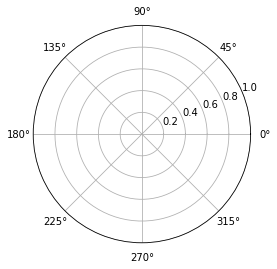

In [11]:
ax = plt.subplot(111, projection='polar')
rstates = list()
thetastates = list()
#ax.plot(theta, r)
#Q Learning Algorithm
#Terminal state q-values are 0. All others are random.
del_r = 1
#q_values[300, 40:50,:, :] = 0
episodes = 1
alpha = 0.1
gamma = 0.9
for i in range(episodes):
    #state = [0, numpy.random.choice(range(360))]
    state = [0, 45]
    #plt.imshow(numpy.mean(q_values, axis = 0), cmap='hot')
    while True:
        prev_state = state
        #del_r, del_theta = numpy.unravel_index(numpy.argmax(q_values[state[0], state[1], :], axis=None), q_values[state[0], state[1], :].shape)
        del_theta = numpy.argmax(q_values[state[0], state[1], :])
        #state, reward = step(environment, prev_state, [del_r, del_theta])
        state, reward = step_angle(environment, prev_state, [del_r, del_theta], 0)

        q_values[prev_state[0], prev_state[1], del_theta] = q_values[prev_state[0], prev_state[1], del_theta] + alpha*(reward+gamma*numpy.max(q_values[state[0], state[1], :]) - q_values[prev_state[0], prev_state[1], del_theta])
        #Take Action A (from set of actions a), observe R and S'
        #Q(A, A) = Q(S, A) + alpha*[R + gamma*maxQ(S', a) - Q(S, A)]
        #S <- S'
        #if reward > 0: 
            #print (reward)
        rstates.append(state[0])
        thetastates.append(state[1])
        if reward == 100:
            break
    #Until S is terminal

In [12]:
def select_state(values, curr_state, del_r, epsilon):
    if numpy.random.rand(1) < epsilon:
        return numpy.argmax(values[(curr_state[0] + del_r)%575, :])
    else:
        return numpy.random.choice(range(len(values[(curr_state[0]+del_r)%575, :])))


In [13]:
def value_step(environment, curr_state, del_r, del_theta):
    r, theta = curr_state[0], curr_state[1]
    state = (r+del_r)%575, del_theta
    reward = environment[state[0], state[1]]
    return state, reward

In [14]:
values = numpy.random.rand(575, 360)
values[280:320, 40:50] = 0
episodes = 100000
alpha = 0.01
gamma = 0.9
del_r = 1
epsilon = 0.5
for i in range(episodes):
    alpha = (episodes - 1)/episodes
    epsilon = (episodes - 1)/episodes
    curr_state = [0, 0]
    while True:
        prev_state = curr_state
        del_theta = select_state(values, curr_state, del_r, epsilon)
        curr_state, reward = value_step(environment, curr_state, del_r, del_theta)
        values[prev_state[0], prev_state[1]] = values[prev_state[0], prev_state[1]] + alpha*(reward+gamma*values[curr_state[0], curr_state[1]] - values[prev_state[0], prev_state[1]])
        if reward == 100:
            break

In [15]:
values = numpy.random.rand(575, 360)
values[280:320, 40:50] = 0
episodes = 1
alpha = 0.01
gamma = 0.9
del_r = 1
epsilon = 0.5
rstates = list()
thetastates = list()
for i in range(episodes):
    alpha = (episodes - 1)/episodes
    curr_state = [0, 0]
    while True:
        prev_state = curr_state
        #del_theta = numpy.argmax(values[(curr_state [0]+ del_r)%575])
        del_theta = select_state(values, curr_state, del_r, epsilon)
        curr_state, reward = value_step(environment, curr_state, del_r, del_theta)
        values[prev_state[0], prev_state[1]] = values[prev_state[0], prev_state[1]] + alpha*(reward+gamma*values[curr_state[0], curr_state[1]] - values[prev_state[0], prev_state[1]])
        rstates.append(curr_state[0])
        thetastates.append(curr_state[1])
        if reward == 100:
            break

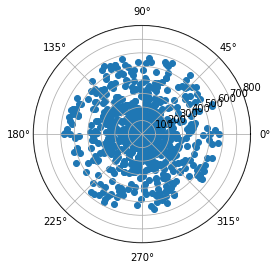

In [16]:
ax = plt.subplot(111, projection='polar')
ax.scatter(numpy.array(thetastates)*2*numpy.pi/360, numpy.array(rstates))

In [129]:
rstates = numpy.array(rstates)
thetastates = numpy.array(thetastates)

In [130]:
rs = numpy.sqrt(rstates[1:]**2 + 1**2 + 2*rstates[1:]*1*numpy.cos(thetastates[1:] - thetastates[:-1]))

In [131]:
x = rstates*numpy.cos(thetastates*2*numpy.pi/360)
y = rstates*numpy.sin(thetastates*2*numpy.pi/360)
X, Y = numpy.meshgrid(x, y)

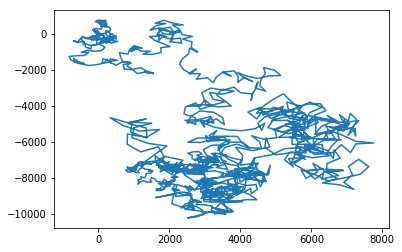

In [132]:
plt.plot(numpy.cumsum(x), numpy.cumsum(y))

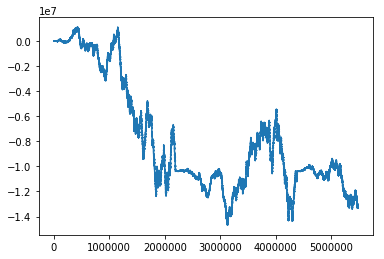

In [133]:
plt.plot(numpy.cumsum(X), numpy.cumsum(Y))

In [2]:
policy_angle = 30

In [27]:
r = numpy.array(range(200))
theta = numpy.repeat(25, repeats=200)
policy_angle = numpy.repeat(1, repeats=200)
angles = theta + numpy.cumsum(policy_angle)

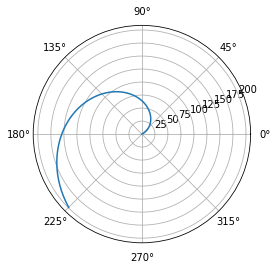

In [28]:
plt.polar(angles*2*numpy.pi/360, r)